In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.misc
import json
from PIL import Image

In [2]:
!nvidia-smi

Tue Feb 27 19:57:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off | 00000000:0A:00.0  On |                  N/A |
|  0%   56C    P5              55W / 215W |    905MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
if torch.cuda.is_available():
    device = torch.device(type="cuda", index=0)
else:
    device = torch.device(type="cpu", index=0)
    
print(device)

cuda:0


In [4]:
train = datasets.MNIST("", train=True, download=True,
                       transform=transforms.Compose([ToTensor()]))
test = datasets.MNIST("", train=False, download=True,
                       transform=transforms.Compose([ToTensor()]))

print(len(train.data[0]))

28


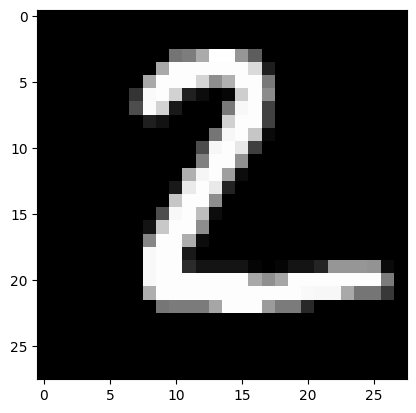

2


In [5]:
plt.imshow(test[1][0].view(28,28), cmap="gray")
plt.show()
print(test[1][1])

In [6]:
batch_size = 64

trainDl = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
testDl = DataLoader(dataset=test, batch_size=batch_size)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        
        self.inp = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=[3,3], stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.max1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        
        self.flatten = nn.Flatten()
        # 7*7*64 = 3136
        self.dense1 = nn.Linear(in_features=3136, out_features=10)
        self.out = nn.BatchNorm1d(num_features=10)
        
    def forward(self, x):
        # activations = []
        x = self.inp(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max1(x)
        # activations.append(x.clone().detach())
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        
        x = self.dense1(x)
        out =self.out(x)
        return F.softmax(out, dim=1)

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss = 0
    num_correct = 0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        pred = model(imgs)
        loss = loss_fn(pred, labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i%100==0:
            running_loss = round(track_loss/(i+1),2)
            running_acc = round((num_correct/((i+1)*batch_size))*100,2)
            print(f"Batch: {i+1}/{len(dataloader)}, Running Loss: {running_loss}, Running Accuracy: {running_acc}")
            
            
        
    epoch_loss = track_loss/len(dataloader)#slightly inaccurate
    epoch_acc = (num_correct/len(dataloader.dataset))*100
    return round(epoch_loss, 2), round(epoch_acc, 2)

def eval(dataloader, model, loss_fn):
    model.eval()
    # data = pd.read_csv(path)
    track_loss = 0
    num_correct = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            pred = model(imgs)
            
            loss = loss_fn(pred, labels)
            track_loss+=loss.item()
            num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
            
            if i%100==0:
                running_loss = round(track_loss/(i+1),2)
                running_acc = round((num_correct/((i+1)*batch_size))*100,2)
                print(f"Batch: {i+1}/{len(dataloader)}, Running Loss: {running_loss}, Running Accuracy: {running_acc}")
                
    epoch_loss = track_loss/len(dataloader)#slightly inaccurate
    epoch_acc = (num_correct/len(dataloader.dataset))*100
    return round(epoch_loss, 2), round(epoch_acc, 2)

In [9]:
model = CNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=lr)
EPOCHS = 1

In [10]:
# train
for i in range(EPOCHS):
    print(f"EPOCH: {i+1}")
    train_epoch_loss, train_epoch_acc = train_one_epoch(trainDl, model, loss_fn, optimizer)
    print(f"Training===> Epoh Loss: {train_epoch_loss}, Epoch Accuracy: {train_epoch_acc}")
    print("-----------------------------------------------------------------------------------------")

EPOCH: 1
Batch: 1/938, Running Loss: 2.33, Running Accuracy: 7.81
Batch: 101/938, Running Loss: 1.83, Running Accuracy: 88.77
Batch: 201/938, Running Loss: 1.78, Running Accuracy: 92.19
Batch: 301/938, Running Loss: 1.75, Running Accuracy: 93.58
Batch: 401/938, Running Loss: 1.72, Running Accuracy: 94.57
Batch: 501/938, Running Loss: 1.7, Running Accuracy: 95.22
Batch: 601/938, Running Loss: 1.69, Running Accuracy: 95.64
Batch: 701/938, Running Loss: 1.67, Running Accuracy: 96.03
Batch: 801/938, Running Loss: 1.66, Running Accuracy: 96.31
Batch: 901/938, Running Loss: 1.65, Running Accuracy: 96.54
Training===> Epoh Loss: 1.64, Epoch Accuracy: 96.6
-----------------------------------------------------------------------------------------


In [11]:
eval(testDl, model, loss_fn)

Batch: 1/157, Running Loss: 1.52, Running Accuracy: 98.44
Batch: 101/157, Running Loss: 1.54, Running Accuracy: 98.61


(1.53, 98.93)

In [12]:
torch.cuda.empty_cache()

# Visualizing Data After Activations

In [13]:
print(model)

CNN(
  (relu): ReLU()
  (inp): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3136, out_features=10, bias=True)
  (out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
model_children = list(model.children())#counter to keep count of the conv layers
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
for l in conv_layers:
    print(l)

Total convolution layers: 4
Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))


In [15]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [22]:
image = test[2][0].view(28,28)
image_np = image.numpy()
image_pil = Image.fromarray(image_np)
image = transform(image_pil)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([1, 28, 28])
Image shape after: torch.Size([1, 1, 28, 28])


In [23]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

4
torch.Size([1, 8, 26, 26])
torch.Size([1, 16, 24, 24])
torch.Size([1, 32, 22, 22])
torch.Size([1, 64, 20, 20])


In [24]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(26, 26)
(24, 24)
(22, 22)
(20, 20)


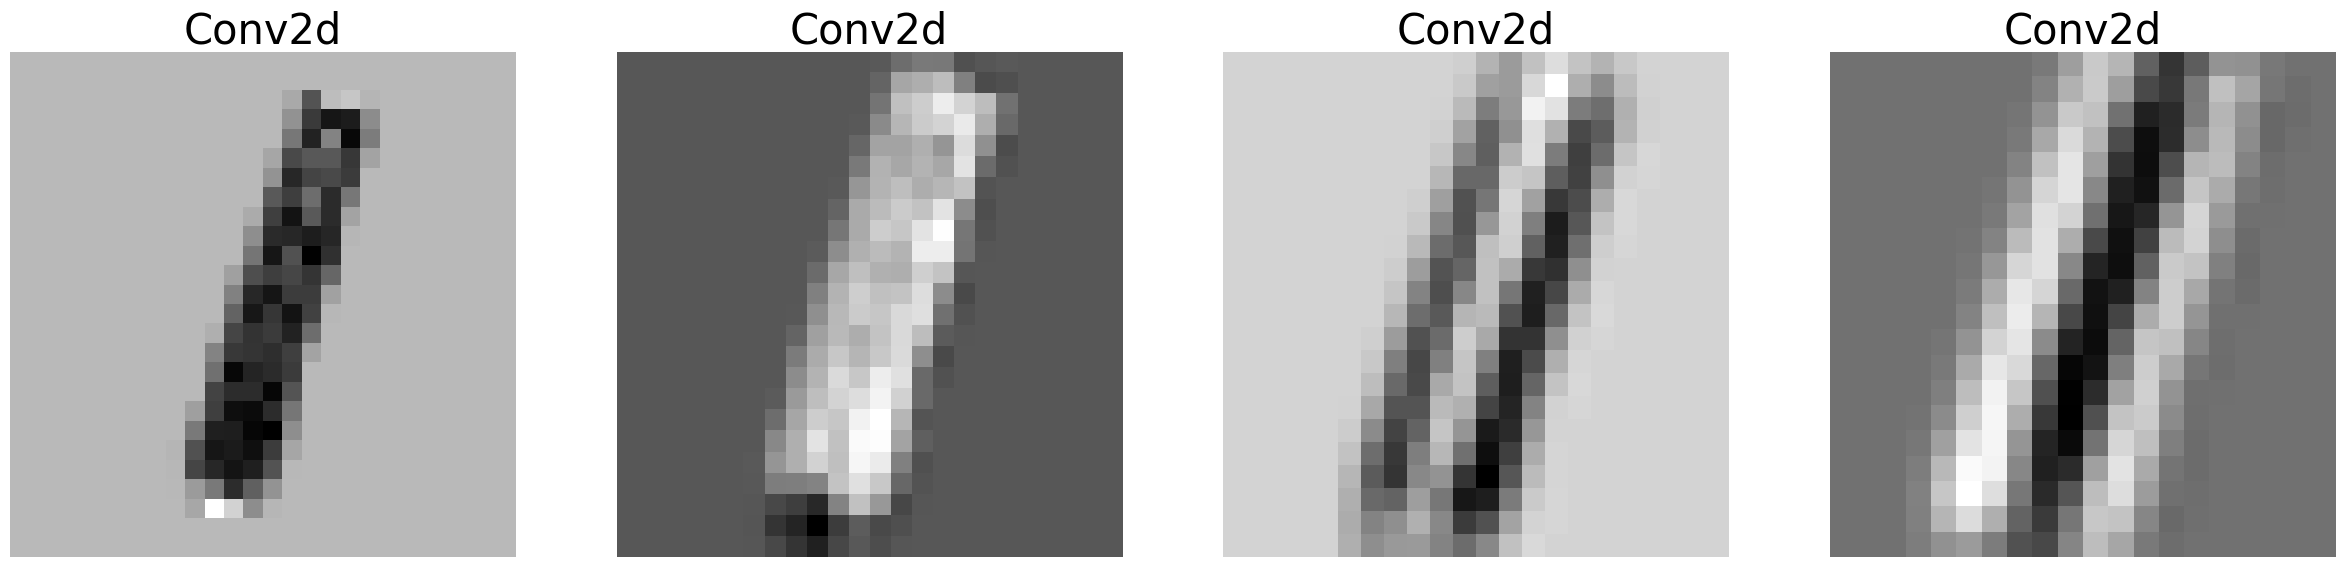

In [25]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i], cmap='gray')
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.show(str('feature_maps.jpg'))

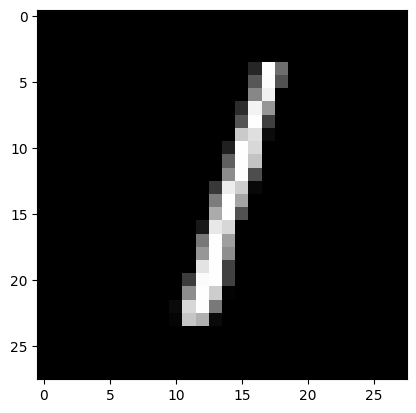

In [27]:
plt.imshow(test[2][0].view(28,28), cmap="gray")
plt.show()
# print(test[1][1])